In [ ]:
#   This is using node2vec, achieving 89% precision. Though the violations are not categorized properly.

In [ ]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.

In [ ]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import numpy as np

In [ ]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec

# Loading data
selinux_data = pd.read_csv('/content/Data/SELinuxRealTE.csv')
attributes_data = pd.read_csv('/content/Data/attributes.csv')
objectclass_data = pd.read_csv('/content/Data/objectclass.csv')

In [ ]:
# Creating an empty directed graph
G_selinux = nx.DiGraph()

# Add nodes and edges from SELinuxRealTE.csv
for index, row in selinux_data.iterrows():
    source = row['Source']
    target = row['Target']
    object_class = row['ObjectClass']
    permission = row['Permission']
    G_selinux.add_edge(source, target, object_class=object_class, permission=permission)

In [ ]:
# Creating an empty directed graph
G_attributes = nx.DiGraph()

# Add attributes to nodes from attributes.csv
for index, row in attributes_data.iterrows():
    node = row['1']
    attributes = row['2'].split(', ')
    G_attributes.add_node(node)
    for attr in attributes:
        G_attributes.add_edge(node, attr)


In [ ]:
# Creating objectclass graph
G_objectclass = nx.Graph()

# Adding object class permissions
for index, row in objectclass_data.iterrows():
    object_class = row['Name']
    permissions = row['Permissions'].split(',')
    G_objectclass.add_node(object_class)
    for perm in permissions:
        G_objectclass.add_edge(object_class, perm)

In [ ]:
# Generating node2vec embeddings with attributes
node2vec = Node2Vec(G_selinux, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Initialize Node2Vec


Computing transition probabilities:   0%|          | 0/4721 [00:00<?, ?it/s]

In [ ]:
# Precomputing the probabilities and generating walks
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [ ]:
# Get node embeddings
embeddings_selinux = {node: model.wv[node] for node in G_selinux.nodes}

In [ ]:
# Applying node2vec to attribute and objectclass graphs
node2vec_attributes = Node2Vec(G_attributes, dimensions=64, walk_length=30, num_walks=200, workers=4)
model_attributes = node2vec_attributes.fit(window=10, min_count=1, batch_words=4)
embeddings_attributes = {node: model_attributes.wv[node] for node in G_attributes.nodes}

node2vec_objectclass = Node2Vec(G_objectclass, dimensions=64, walk_length=30, num_walks=200, workers=4)
model_objectclass = node2vec_objectclass.fit(window=10, min_count=1, batch_words=4)
embeddings_objectclass = {node: model_objectclass.wv[node] for node in G_objectclass.nodes}

Computing transition probabilities:   0%|          | 0/5234 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

In [ ]:
# Combine embeddings into a single dictionary
all_embeddings = {}

In [ ]:
# Add SELinux embeddings
for node, emb in embeddings_selinux.items():
    all_embeddings[node] = emb

In [ ]:
# Add attributes embeddings
for node, emb in embeddings_attributes.items():
    if node in all_embeddings:
        all_embeddings[node] = np.concatenate((all_embeddings[node], emb))
    else:
        all_embeddings[node] = emb

In [ ]:
# Add object class embeddings
for node, emb in embeddings_objectclass.items():
    if node in all_embeddings:
        all_embeddings[node] = np.concatenate((all_embeddings[node], emb))
    else:
        all_embeddings[node] = emb

In [ ]:
import numpy as np

def get_embedding(node, embeddings, dimension):
    """Retrieve embedding for a node or return a zero vector if not found."""
    if node in embeddings:
        return embeddings[node]
    else:
        return np.zeros(dimension)

def pad_embeddings(embeddings, dimension):
    """Pad embeddings to ensure they all have the same dimension."""
    for node in embeddings:
        if len(embeddings[node]) < dimension:
            embeddings[node] = np.concatenate((embeddings[node], np.zeros(dimension - len(embeddings[node]))))
    return embeddings


In [ ]:
# The dimension for each embedding type
dimension_selinux = 64
dimension_attributes = 64
dimension_objectclass = 64

# Padding embeddings to ensure they all have the same length
embeddings_selinux = pad_embeddings(embeddings_selinux, dimension_selinux)
embeddings_attributes = pad_embeddings(embeddings_attributes, dimension_attributes)
embeddings_objectclass = pad_embeddings(embeddings_objectclass, dimension_objectclass)

# Combining embeddings into a single dictionary
all_embeddings = {}
for node in set(embeddings_selinux) | set(embeddings_attributes) | set(embeddings_objectclass):
    emb_selinux = get_embedding(node, embeddings_selinux, dimension_selinux)
    emb_attributes = get_embedding(node, embeddings_attributes, dimension_attributes)
    emb_objectclass = get_embedding(node, embeddings_objectclass, dimension_objectclass)
    combined_emb = np.concatenate((emb_selinux, emb_attributes, emb_objectclass))
    all_embeddings[node] = combined_emb


In [ ]:
# Convert the combined embeddings to a numpy array
embedding_matrix = np.array(list(all_embeddings.values()))

# Generate a list of node names corresponding to the embeddings
node_names = list(all_embeddings.keys())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embedding_matrix, np.zeros(len(embedding_matrix)), test_size=0.2, random_state=42)


In [ ]:
# Train Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(X_train)

# Predict anomalies using Isolation Forest
pred_if = isolation_forest.predict(X_test)
anomalies_if = [node_names[i] for i, pred in enumerate(pred_if) if pred == -1]

In [ ]:
# Predict anomalies using Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
pred_lof = lof.fit_predict(X_test)
anomalies_lof = [node_names[i] for i, pred in enumerate(pred_lof) if pred == -1]


In [ ]:
# Predict anomalies using One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.1)
ocsvm.fit(X_train)
pred_ocsvm = ocsvm.predict(X_test)
anomalies_ocsvm = [node_names[i] for i, pred in enumerate(pred_ocsvm) if pred == -1]

In [ ]:
# Output anomalies for manual verification
print("Anomalies detected by Isolation Forest:")
print(anomalies_if)

print("Anomalies detected by Local Outlier Factor:")
print(anomalies_lof)

print("Anomalies detected by One-Class SVM:")
print(anomalies_ocsvm)

Anomalies detected by Isolation Forest:
['cgconfig_initrc_exec_t', 'afs_ka_client_packet_t', 'tor_client_packet_t', 'motion_exec_t', 'asterisk_var_lib_t', 'staff_usertype', 'ssh_server_packet_t', 'afs_fs_client_packet_t', 'netlabel_mgmt_unit_file_t', 'rlogind_t', 'dovecot_spool_t', ' update', 'postfix_master_t', 'gssproxy_exec_t', 'rtsp_client_packet_t', 'pegasus_openlmi_storage_tmp_t', 'mojomojo_script_exec_t', 'telepathy_sofiasip_t', 'piranha_domain', 'getty_tmp_t', 'unconfined_service_t', 'asterisk_t', 'gds_db_client_packet_t', 'sepgsql_safe_lang_t', 'zarafa_gateway_var_run_t', 'pki_tps_script_exec_t', 'mon_procd_t', ' recv_msg', 'systemd_logind_t', 'tape_device_t', 'ntop_tmp_t', 'tcs_client_packet_t', 'certmaster_t', 'rsync_data_t', 'httpd_unit_file_t', 'rngd_t', 'NetworkManager_etc_t', 'ntop_exec_t', 'nutups_cgi_content_t', 'lldpad_var_lib_t', 'milter_data_type', 'puppet_log_t', ' getserv', 'apmd_tmp_t', 'krb5_home_t', 'printer_t', 'kismet_var_run_t', 'inetd_child_port_t', 'dcc_se

In [ ]:
# # Number of anomalies detected by each method
# num_anomalies_if = len(anomalies_if)
# num_anomalies_lof = len(anomalies_lof)
# num_anomalies_ocsvm = len(anomalies_ocsvm)

# print(f"Number of anomalies detected by Isolation Forest: {num_anomalies_if}")
# print(f"Number of anomalies detected by Local Outlier Factor: {num_anomalies_lof}")
# print(f"Number of anomalies detected by One-Class SVM: {num_anomalies_ocsvm}")

# # Proportion of anomalies detected by each method
# proportion_anomalies_if = num_anomalies_if / len(X_test)
# proportion_anomalies_lof = num_anomalies_lof / len(X_test)
# proportion_anomalies_ocsvm = num_anomalies_ocsvm / len(X_test)

# print(f"Proportion of anomalies detected by Isolation Forest: {proportion_anomalies_if:.2%}")
# print(f"Proportion of anomalies detected by Local Outlier Factor: {proportion_anomalies_lof:.2%}")
# print(f"Proportion of anomalies detected by One-Class SVM: {proportion_anomalies_ocsvm:.2%}")



Number of anomalies detected by Isolation Forest: 119
Number of anomalies detected by Local Outlier Factor: 113
Number of anomalies detected by One-Class SVM: 138
Proportion of anomalies detected by Isolation Forest: 10.54%
Proportion of anomalies detected by Local Outlier Factor: 10.01%
Proportion of anomalies detected by One-Class SVM: 12.22%


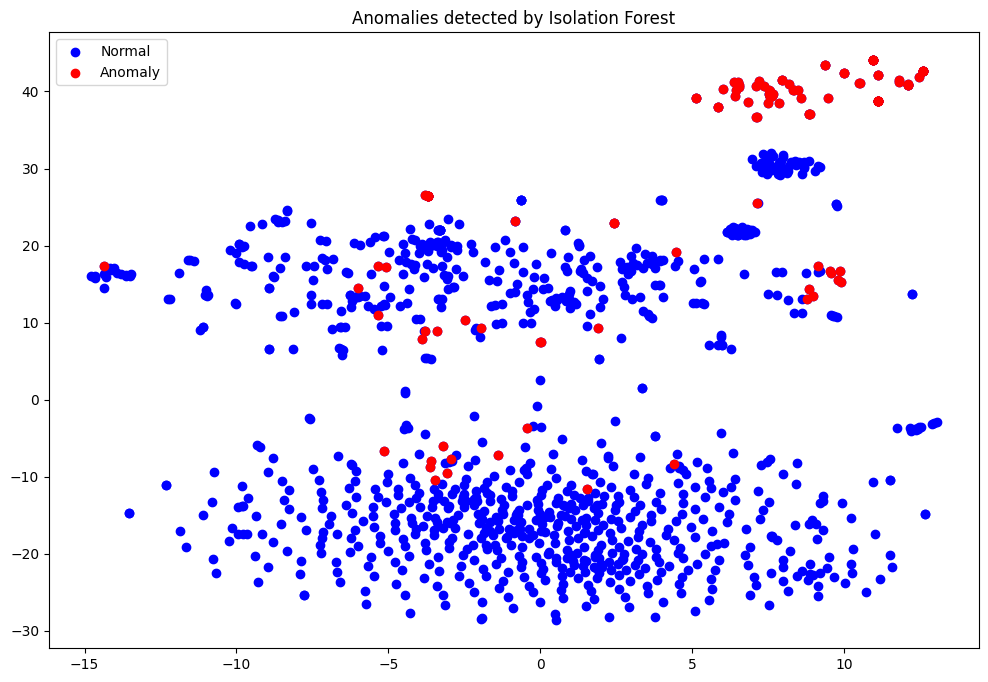

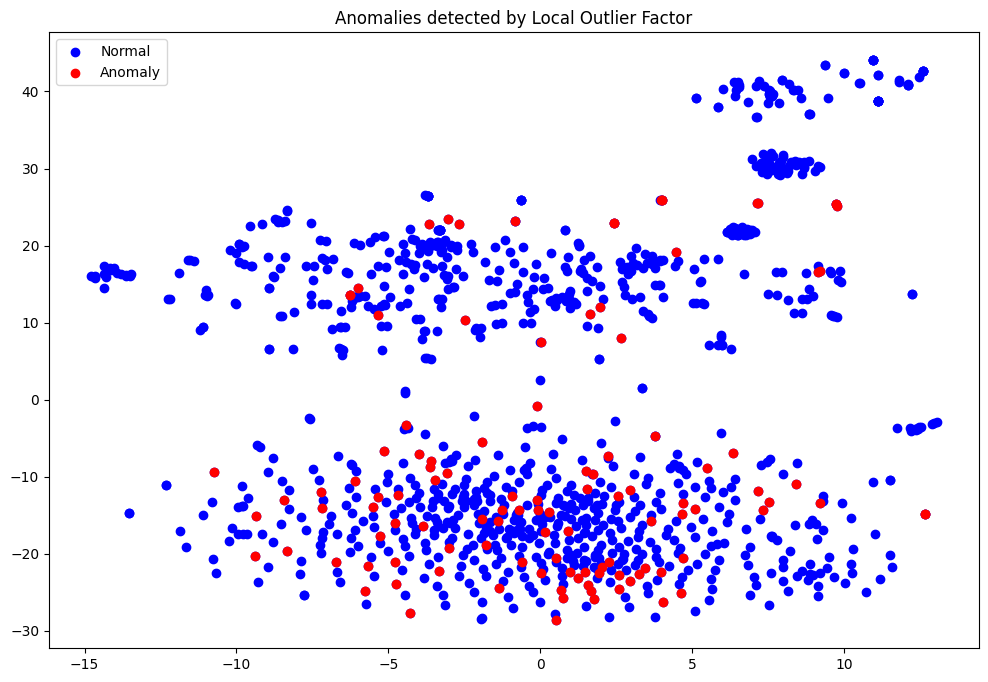

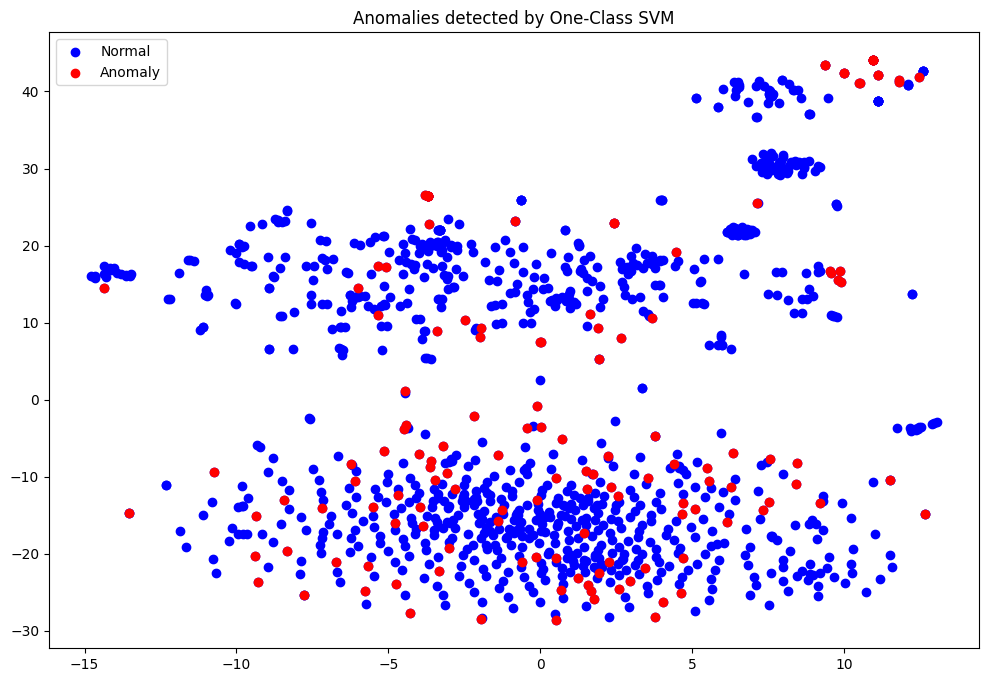

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_test)

# Creating a scatter plot for the anomalies
def plot_anomalies(X_embedded, anomalies, title):
    plt.figure(figsize=(12, 8))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c='blue', label='Normal')

    # Highlight anomalies
    anomaly_indices = [node_names.index(node) for node in anomalies if node in node_names]
    plt.scatter(X_embedded[anomaly_indices, 0], X_embedded[anomaly_indices, 1], c='red', label='Anomaly')

    plt.title(title)
    plt.legend()
    plt.show()

# Plot anomalies detected by each method
plot_anomalies(X_embedded, anomalies_if, 'Anomalies detected by Isolation Forest')
plot_anomalies(X_embedded, anomalies_lof, 'Anomalies detected by Local Outlier Factor')
plot_anomalies(X_embedded, anomalies_ocsvm, 'Anomalies detected by One-Class SVM')


In [ ]:
def inject_anomalies(X, contamination=0.1):
    """Inject synthetic anomalies into the dataset."""
    np.random.seed(42)
    n_anomalies = int(contamination * X.shape[0])
    anomalies = np.random.uniform(low=-1, high=1, size=(n_anomalies, X.shape[1]))
    X_with_anomalies = np.vstack([X, anomalies])
    y_with_anomalies = np.hstack([np.zeros(X.shape[0]), np.ones(n_anomalies)])
    return X_with_anomalies, y_with_anomalies

# Inject synthetic anomalies into the test set
X_test_with_anomalies, y_test_with_anomalies = inject_anomalies(X_test, contamination=0.1)




In [ ]:
# Train Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators = 100)
isolation_forest.fit(X_train)


IsolationForest(contamination=0.1, random_state=42)

In [ ]:
# Train Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
# Note: LOF does not have a fit method; it directly predicts on the data


In [ ]:
# Train One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.1)
ocsvm.fit(X_train)

OneClassSVM(gamma=0.001, nu=0.1)

In [ ]:
# Predict anomalies using Isolation Forest
pred_if = isolation_forest.predict(X_test_with_anomalies)
pred_if = np.where(pred_if == 1, 0, 1)  # Convert output to binary labels (1 for anomaly)

# Predict anomalies using Local Outlier Factor
pred_lof = lof.fit_predict(X_test_with_anomalies)
pred_lof = np.where(pred_lof == 1, 0, 1)  # Convert output to binary labels (1 for anomaly)

# Predict anomalies using One-Class SVM
pred_ocsvm = ocsvm.predict(X_test_with_anomalies)
pred_ocsvm = np.where(pred_ocsvm == 1, 0, 1)  # Convert output to binary labels (1 for anomaly)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return precision, recall, f1, auc

# Evaluate Isolation Forest
precision_if, recall_if, f1_if, auc_if = evaluate_model(y_test_with_anomalies, pred_if)

# Evaluate Local Outlier Factor
precision_lof, recall_lof, f1_lof, auc_lof = evaluate_model(y_test_with_anomalies, pred_lof)

# Evaluate One-Class SVM
precision_ocsvm, recall_ocsvm, f1_ocsvm, auc_ocsvm = evaluate_model(y_test_with_anomalies, pred_ocsvm)

# Print evaluation results
print(f"Isolation Forest: Precision={precision_if:.2f}, Recall={recall_if:.2f}, F1-Score={f1_if:.2f}, AUC-ROC={auc_if:.2f}")
print(f"Local Outlier Factor: Precision={precision_lof:.2f}, Recall={recall_lof:.2f}, F1-Score={f1_lof:.2f}, AUC-ROC={auc_lof:.2f}")
print(f"One-Class SVM: Precision={precision_ocsvm:.2f}, Recall={recall_ocsvm:.2f}, F1-Score={f1_ocsvm:.2f}, AUC-ROC={auc_ocsvm:.2f}")


Isolation Forest: Precision=0.48, Recall=1.00, F1-Score=0.65, AUC-ROC=0.95
Local Outlier Factor: Precision=0.89, Recall=0.98, F1-Score=0.93, AUC-ROC=0.98
One-Class SVM: Precision=0.45, Recall=1.00, F1-Score=0.62, AUC-ROC=0.94
